In [1]:
from astropy.table import Table
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from astropy.io import ascii
from matplotlib.patches import Rectangle, Ellipse, Circle
import Paths.Paths as paths
import seaborn as sns

Path = paths.filepaths()


/home/t.yoo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from matplotlib import colors
import astropy.units as u
import matplotlib as mpl
plt.rcParams['axes.labelsize']=60
plt.rcParams['xtick.labelsize']=50
plt.rcParams['ytick.labelsize']=50
plt.rcParams['axes.titlesize']=60
mpl.rcParams['axes.linewidth'] = 10
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
class core_catdata():
    def __init__(self,catfile, almaimf_beam,  start_coreno, hrfits=None,band='B3', recommend_criteria = 'b6', include_ff=False ):
        catdata_w51e = ascii.read(catfile,data_start=0,format='commented_header', header_start=120,  comment="!")
        geo_avg_beam = np.sqrt(almaimf_beam.major.to(u.arcsec).value*almaimf_beam.minor.to(u.arcsec).value)
        corr_factor = catdata_w51e['AFWHM02'] * catdata_w51e['BFWHM02'] / catdata_w51e['AFWHM03'] / catdata_w51e['BFWHM03']
        numcore_tot = len(catdata_w51e['AFWHM02'])
        if include_ff:
            coreno_merged = start_coreno[0] + start_coreno[1]
            print('coreno_merged',coreno_merged)
            coreno_merged.sort()
            coreno_start = coreno_merged
            print('coreno_start',coreno_start)
        else:
            coreno_start = start_coreno[0]
        coreidx_start = [i for i in range(numcore_tot) if catdata_w51e['NO'][i] in coreno_start]
        if recommend_criteria == 'b6b3':
            coreidx = [idx for idx in coreidx_start if all([np.abs(catdata_w51e['GOODM02'][idx])>1,  
                       np.abs(catdata_w51e['SIGNM02'][idx])>1,  
                       catdata_w51e['FXP_BST02'][idx]/catdata_w51e['FXP_ERR02'][idx]>2, 
                       catdata_w51e['FXT_BST02'][idx]/catdata_w51e['FXT_ERR02'][idx]>2, 
                       catdata_w51e['AFWHM02'][idx]/catdata_w51e['BFWHM02'][idx]<2 ,
                        catdata_w51e['FOOA02'][idx]/catdata_w51e['AFWHM02'][idx]>1.15 ,
                        np.sqrt(catdata_w51e['AFWHM03'][idx]*catdata_w51e['BFWHM03'][idx]) <4 * geo_avg_beam  ,
                        catdata_w51e['AFWHM03'][idx]/catdata_w51e['BFWHM03'][idx]<=2 ,
                        np.abs(catdata_w51e['SIGNM03'][idx])>1 ,
                        catdata_w51e['FXP_BST03'][idx]/catdata_w51e['FXP_ERR03'][idx]>1,  
                        catdata_w51e['FXT_BST03'][idx]/catdata_w51e['FXT_ERR03'][idx]>1])]
        elif recommend_criteria == 'b6':
            coreidx = coreidx_start                  
       
        
        if hrfits is not None:
            yso_image = fits.open(hrfits)[0].data[0][0]
            hrhdr = fits.open(hrfits)[0].header
            inside_idx = exist_inside_FOV(catdata_w51e['WCS_ACOOR'], catdata_w51e['WCS_DCOOR'], yso_image, hrhdr)
    
            rec_ind = np.intersect1d(coreidx, inside_idx)
        else:
            rec_ind = coreidx
        print('total core number = ', len(catdata_w51e['WCS_ACOOR']))
        print(hrfits)
        print('robust %s measurement before applying FoV criteria = '%band, len(coreidx))
        print('robust %s measurement after applying FoV criteria = '%band, len(rec_ind))
       
        self.sky_ra = catdata_w51e['WCS_ACOOR'][rec_ind]
        self.sky_dec = catdata_w51e['WCS_DCOOR'][rec_ind]
        self.pix_x = catdata_w51e['XCO_P'][rec_ind]
        self.pix_y = catdata_w51e['YCO_P'][rec_ind]
        
        if band=='B3':
            bandind = 3
        else:
            bandind = 2

        self.afwhm = catdata_w51e['AFWHM0%d'%bandind][rec_ind] #arcsec
        self.bfwhm = catdata_w51e['BFWHM0%d'%bandind][rec_ind]

        self.asize = catdata_w51e['ASIZE0%d'%bandind][rec_ind]
        self.bsize = catdata_w51e['BSIZE0%d'%bandind][rec_ind]

        self.theta = catdata_w51e['THETA0%d'%bandind][rec_ind]
        
        self.flux = catdata_w51e['FXT_BST0%d'%bandind][rec_ind]
        self.fluxerr = catdata_w51e['FXT_ERR0%d'%bandind][rec_ind]
        self.flux_g = catdata_w51e['FXT_ALT0%d'%bandind][rec_ind]

        self.fooa = catdata_w51e['FOOA0%d'%bandind][rec_ind]
        self.foob = catdata_w51e['FOOB0%d'%bandind][rec_ind]
        
        self.int_peak = catdata_w51e['FXP_BST0%d'%bandind][rec_ind]
        self.interr_peak = catdata_w51e['FXP_ERR0%d'%bandind][rec_ind]
        
        self.size = (catdata_w51e['AFWHM0%d'%bandind][rec_ind]*catdata_w51e['BFWHM0%d'%bandind][rec_ind]**2)**(1/3) #arcsec


        self.no = catdata_w51e['NO'][rec_ind]

        
        
        rescaled_3mmflux = catdata_w51e['FXT_BST03'][rec_ind] * catdata_w51e['AFWHM02'][rec_ind] * catdata_w51e['BFWHM02'][rec_ind] / catdata_w51e['AFWHM03'][rec_ind]/catdata_w51e['BFWHM03'][rec_ind]
        gamma = np.log10(catdata_w51e['FXT_BST02'][rec_ind] / rescaled_3mmflux)/np.log10(228.918/101.426)
        self.woffind = np.where(gamma>2)[0]
        self.wffind = np.where(gamma<2)[0]
        self.rec_ind = rec_ind


def count_points_in_ellipse(xcen,ycen,major,minor,pa,xpos,ypos):
    # caclulate foci positions 
    # must be full major, minor not semi major, minor
    fodx = np.cos(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    fody = np.sin(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    
    fox1 = xcen + fodx
    foy1 = ycen + fody
    
    fox2 = xcen - fodx
    foy2 = ycen - fody
    
    dist1 = np.sqrt((xpos-fox1)**2+(ypos-foy1)**2)
    dist2 = np.sqrt((xpos-fox2)**2+(ypos-foy2)**2)
    
    isinside = np.where(dist1+dist2<major)[0]
    
    return len(isinside), list(isinside)

def exist_inside_FOV(xcore_sky, ycore_sky, yso_image, hrhdr):
    isfinite = np.where(np.isfinite(yso_image))
    xfinite1 = np.min(isfinite[0])
    xfinite2 = np.max(isfinite[0])
    yfinite1 = np.min(isfinite[1])
    yfinite2 = np.max(isfinite[1])
     
    xcen = (xfinite1 + xfinite2)/2
    ycen = (yfinite1 + yfinite2)/2

    wcs_hr = WCS(hrhdr,naxis=2)
    xypos = wcs_hr.wcs_world2pix(np.vstack((xcore_sky,ycore_sky)).T,0)
    
    rad = np.abs(xfinite2 - xcen)
    
    
    dist = np.sqrt((xypos[:,0]- xcen)**2+(xypos[:,1]-ycen)**2)
    isinside = np.where(dist<rad)[0]
    
    return isinside
def plot_catalog_on_image(ax, hdr_image,  catdatadir, idx_start, isb3=False,beam=None,
                         color='cyan',lw=4,aperture='fwhm+beam',xysource=None,ls='solid',fontsize=30
                          ):
    catdata = ascii.read(catdatadir,data_start=0,format='commented_header', header_start=120,  comment="!")
    idx = [i for i in range(len(catdata['NO'])) if catdata['NO'][i] in idx_start]
    sky_ra = catdata['WCS_ACOOR'][idx]
    sky_dec = catdata['WCS_DCOOR'][idx]
    no = catdata['NO'][idx]
    if isb3:
        bandlabel = '03'
    else:
        bandlabel = '02'
    fooa = catdata['FOOA%s'%bandlabel][idx]
    foob = catdata['FOOB%s'%bandlabel][idx]
    theta = catdata['THETA%s'%bandlabel][idx]
    afwhm = catdata['AFWHM%s'%bandlabel][idx]
    bfwhm = catdata['BFWHM%s'%bandlabel][idx]
   
    
    skypos = np.vstack((sky_ra,sky_dec)).T

    
    wcsNB = WCS(hdr_image,naxis=2)

    xypos = wcsNB.wcs_world2pix(skypos,0)
    xpos = xypos[:,0]
    ypos = xypos[:,1]
    
    pixel_scale = wcsNB.proj_plane_pixel_scales()[0]
        
    indexlist = []
    for i in range(len(xypos)):
        if aperture is 'footprint':
            major = fooa[i]/3600/pixel_scale.value
            minor = foob[i]/3600/pixel_scale.value
            pa = theta[i]
        elif aperture is 'fwhm+beam':
            meanbeamsize = (beam.major.value+beam.minor.value)/4
            major = (afwhm[i]/3600+meanbeamsize)/pixel_scale.value
            minor = (bfwhm[i]/3600+meanbeamsize)/pixel_scale.value
            pa = theta[i]
        elif aperture is 'beam':
            major = beam.major.value/pixel_scale.value
            minor = beam.minor.value/pixel_scale.value
            pa = beam.pa.value
    
        ellipse = Ellipse(xypos[i],width=major,height=minor,facecolor='none',
                        angle=pa+90,edgecolor=color,lw=lw,ls=ls)
        
        ax.add_patch(ellipse)
        if xysource is not None:
            numsource, indsource = count_points_in_ellipse(xpos[i],ypos[i],major,minor,pa+90,xysource[:,0],xysource[:,1])
            

            ax.text(xpos[i]+50,ypos[i]+70,'%d'%numsource,color='w',fontsize=fontsize,clip_on=True)
            indexlist.append(indsource)
    if xysource is not None:
        return indexlist
    
def plot_dendrogram(ax, catalog , wcsNB=None,legend=True, size=40,color='r' ):
    if wcsNB is not None:
        xsky = catalog['x_sky']
        ysky = catalog['y_sky']
        xysky = np.vstack((xsky, ysky)).T
        xypos = wcsNB.wcs_world2pix(xysky,0)
        xpos = xypos[:,0]
        ypos = xypos[:,1]
        
    else:
        xpos = catalog['x_pix']
        ypos = catalog['y_pix']
    print(xpos,ypos)
    kind = catalog['kind']
    
    #detected in both band
    ind1 = np.where(kind==0)[0]
    print('ind1',ind1)
    ax.scatter(xpos[ind1], ypos[ind1], s=size, marker='x',color=color,label='B3B6')
    #detected in only one band
    ind2 = np.where(kind==1)[0]
    ax.scatter(xpos[ind2], ypos[ind2], s=size-10, marker='o',color='greenyellow',label='B3')
    ind3 = np.where(kind==2)[0]
    ax.scatter(xpos[ind3], ypos[ind3], s=size-10, marker='s',color='cyan',label='B6')
    
def plot_dendrogram_new(ax, catalog , wcsNB=None,legend=True, size=80,color='cyan',band='b6',facecolor='none' ):
    if band=='b6':
        otherband='b3'
    elif band=='b3':
        otherband='b6'
    xsky = catalog['%s_xsky'%band]
    ysky = catalog['%s_ysky'%band]
    xysky = np.vstack((xsky, ysky)).T
    xypos = wcsNB.wcs_world2pix(xysky,0)
    xpos = xypos[:,0]
    ypos = xypos[:,1]
    
    xsky_otherband = catalog['%s_xsky'%otherband]
    ysky_otherband = catalog['%s_ysky'%otherband]
    xysky_otherband = np.vstack((xsky_otherband, ysky_otherband)).T
    xypos_otherband = wcsNB.wcs_world2pix(xysky_otherband,0)
    xpos_otherband = xypos_otherband[:,0]
    ypos_otherband = xypos_otherband[:,1]
    colors=sns.color_palette("tab10")


 
    for i in range(len(xpos)):
        if xsky[i]<0:
            color='magenta'
            x = xpos_otherband[i]
            y = ypos_otherband[i]
        elif catalog['%s_xsky'%otherband][i]<0:
            color='yellow'
            x = xpos[i]
            y = ypos[i]
        elif catalog['group'][i]==0:
            color=colors[0]
            x = xpos[i]
            y = ypos[i]
        elif catalog['group'][i]==1:
            color=colors[1]
            x = xpos[i]
            y = ypos[i]
        else:
            color=colors[2]
            x = xpos[i]
            y = ypos[i]
        ax.scatter(x,y, s=size, marker='o',edgecolor=color,facecolor=facecolor)
                        
def plot_dendrogram_circle(ax, catalog , wcsNB=None,legend=True, size=80,color='cyan',band='b6',lw=4,fill=False):
    if band=='b6':
        otherband='b3'
    elif band=='b3':
        otherband='b6'
    xsky = catalog['%s_xsky'%band]
    ysky = catalog['%s_ysky'%band]
    xysky = np.vstack((xsky, ysky)).T
    xypos = wcsNB.wcs_world2pix(xysky,0)
    xpos = xypos[:,0]
    ypos = xypos[:,1]
    
    xsky_otherband = catalog['%s_xsky'%otherband]
    ysky_otherband = catalog['%s_ysky'%otherband]
    xysky_otherband = np.vstack((xsky_otherband, ysky_otherband)).T
    xypos_otherband = wcsNB.wcs_world2pix(xysky_otherband,0)
    xpos_otherband = xypos_otherband[:,0]
    ypos_otherband = xypos_otherband[:,1]

 
    for i in range(len(xpos)):
        if xsky[i]<0:
            color='magenta'
            x = xpos_otherband[i]
            y = ypos_otherband[i]
        elif catalog['%s_xsky'%otherband][i]<0:
            color='yellow'
            x = xpos[i]
            y = ypos[i]
        elif catalog['alpha'][i]<1.7:
            color='springgreen'
            x = xpos[i]
            y = ypos[i]
        else:
            color='cyan'
            x = xpos[i]
            y = ypos[i]
        circle = Circle((x,y),radius=size, color=color,facecolor='none',lw=lw,fill=fill)
        ax.add_patch(circle)
        
def plot_dendrogram_arrow(ax, catalog ,extent=[],downarrow=[], wcsNB=None,legend=True, size=80,color='cyan',band='b6',lw=4,fill=False,xsort=True):
    if band=='b6':
        otherband='b3'
    elif band=='b3':
        otherband='b6'
    xsky = catalog['%s_xsky'%band]
    ysky = catalog['%s_ysky'%band]
    xysky = np.vstack((xsky, ysky)).T
    xypos = wcsNB.wcs_world2pix(xysky,0)
    
    xpos = xypos[:,0]
    ypos = xypos[:,1]
    
    xsky_otherband = catalog['%s_xsky'%otherband]
    ysky_otherband = catalog['%s_ysky'%otherband]
    xysky_otherband = np.vstack((xsky_otherband, ysky_otherband)).T
    xypos_otherband = wcsNB.wcs_world2pix(xysky_otherband,0)
    xpos_otherband = xypos_otherband[:,0]
    ypos_otherband = xypos_otherband[:,1]
    
    x_both = np.array([xpos[i] if xsky[i]>0 else xpos_otherband[i] for i in range(len(xpos))])
    y_both = np.array([ypos[i] if xsky[i]>0 else ypos_otherband[i] for i in range(len(xpos))])

    
    insideind = np.where((x_both>extent[0])&(x_both<extent[1])&(y_both>extent[2])&(y_both<extent[3]))[0]
    
    x_both_inside = x_both[insideind]
    y_both_inside = y_both[insideind]
    
    if xsort:
        sortind = np.argsort(x_both_inside)
    else:
        sortind = np.argsort(y_both_inside)
    
    x_both_inside = x_both_inside[sortind]
    y_both_inside = y_both_inside[sortind]

        
        
 
    colors=sns.color_palette("tab10")


 
    for i in range(len(xpos)):
        if xsky[i]<0:
            color='magenta'
            x = xpos_otherband[i]
            y = ypos_otherband[i]
        elif catalog['%s_xsky'%otherband][i]<0:
            color='yellow'
            x = xpos[i]
            y = ypos[i]
        elif catalog['group'][i]==0:
            color=colors[0]
            x = xpos[i]
            y = ypos[i]
        elif catalog['group'][i]==1:
            color=colors[1]
            x = xpos[i]
            y = ypos[i]
        else:
            color=colors[2]
            x = xpos[i]
            y = ypos[i]
        if i in downarrow:
            arrowoffset = -50
        else:
            arrowoffset = 50
        print(i,x,y)    
        ax.annotate("",xy=(x,y+arrowoffset/7), xycoords='data', textcoords='offset pixels',
                    arrowprops=dict(width=8, headwidth=20,ec=color,fc=color, ),xytext=(0,arrowoffset),fontsize=30,color=color)
      
                        
                        
def add_scale_bar(ax, xpos,ypos,scale, pixel_scale, dist,height=20,color='w',pad=40,size=40,xoffset=0.05, forceint=False):
    phy_pix_scale = (pixel_scale * dist).to(u.kpc*u.rad)/u.rad
    print(phy_pix_scale.to(u.au))
    scaled_scale = (scale/phy_pix_scale).to(u.rad/u.rad)
    print(scaled_scale, xpos,ypos, height)
    ax.add_patch(Rectangle((xpos,ypos),scaled_scale.value,height,color=color))
    if forceint:
        if scale.unit.is_equivalent(u.pc):
            unit = 'pc'
        elif scale.unit.is_equivalent(u.au):
            unit = 'au'
        ax.text(xpos+(0.4+xoffset)*scaled_scale, ypos+pad, "%i %s"%(scale.value, unit), color=color,fontsize=size)
    else:
        ax.text(xpos+(0.4+xoffset)*scaled_scale, ypos+pad, f"{scale}", color=color,fontsize=size)
    
   

def add_beam(ax,xpos,ypos,beam, pixel_scale,color='w',square=False,square_size=800):
    width = beam.major / pixel_scale
    height = beam.minor /pixel_scale
    angle = beam.pa
    ax.add_patch(Ellipse((xpos,ypos),width.value,height.value,angle.value+90,color=color))
    if square:
        ax.scatter(xpos,ypos,facecolor='none', edgecolor=color,s=square_size,marker='s')

total core number =  127
/orange/adamginsburg/w51/TaehwaYoo/2017.1.00293.S_W51_B3_LB/may2021_successful_imaging/w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits
robust B3 measurement before applying FoV criteria =  99
robust B3 measurement after applying FoV criteria =  87
total core number =  127
None
robust B3 measurement before applying FoV criteria =  99
robust B3 measurement after applying FoV criteria =  99


InconsistentTableError: 
ERROR: Unable to guess table format with the guesses listed below:
Reader:FastCommentedHeader comment: '!' data_start: 0 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 120
Reader:CommentedHeader comment: '!' data_start: 0 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 120 quotechar: '"'
Reader:CommentedHeader comment: '!' data_start: 0 delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 120 quotechar: "'"
Reader:CommentedHeader comment: '!' data_start: 0 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 120 quotechar: '"'
Reader:CommentedHeader comment: '!' data_start: 0 delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 120 quotechar: "'"
Reader:CommentedHeader comment: '!' data_start: 0 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 120 quotechar: '"'
Reader:CommentedHeader comment: '!' data_start: 0 delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 120 quotechar: "'"
Reader:CommentedHeader comment: '!' data_start: 0 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 120 quotechar: '"'
Reader:CommentedHeader comment: '!' data_start: 0 delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 120 quotechar: "'"
Reader:CommentedHeader comment: '!' data_start: 0 fast_reader: {'enable': True} fill_values: [('', '0')] header_start: 120

************************************************************************
** ERROR: Unable to guess table format with the guesses listed above. **
**                                                                    **
** To figure out why the table did not read, use guess=False and      **
** fast_reader=False, along with any appropriate arguments to read(). **
** In particular specify the format and any known attributes like the **
** delimiter.                                                         **
************************************************************************

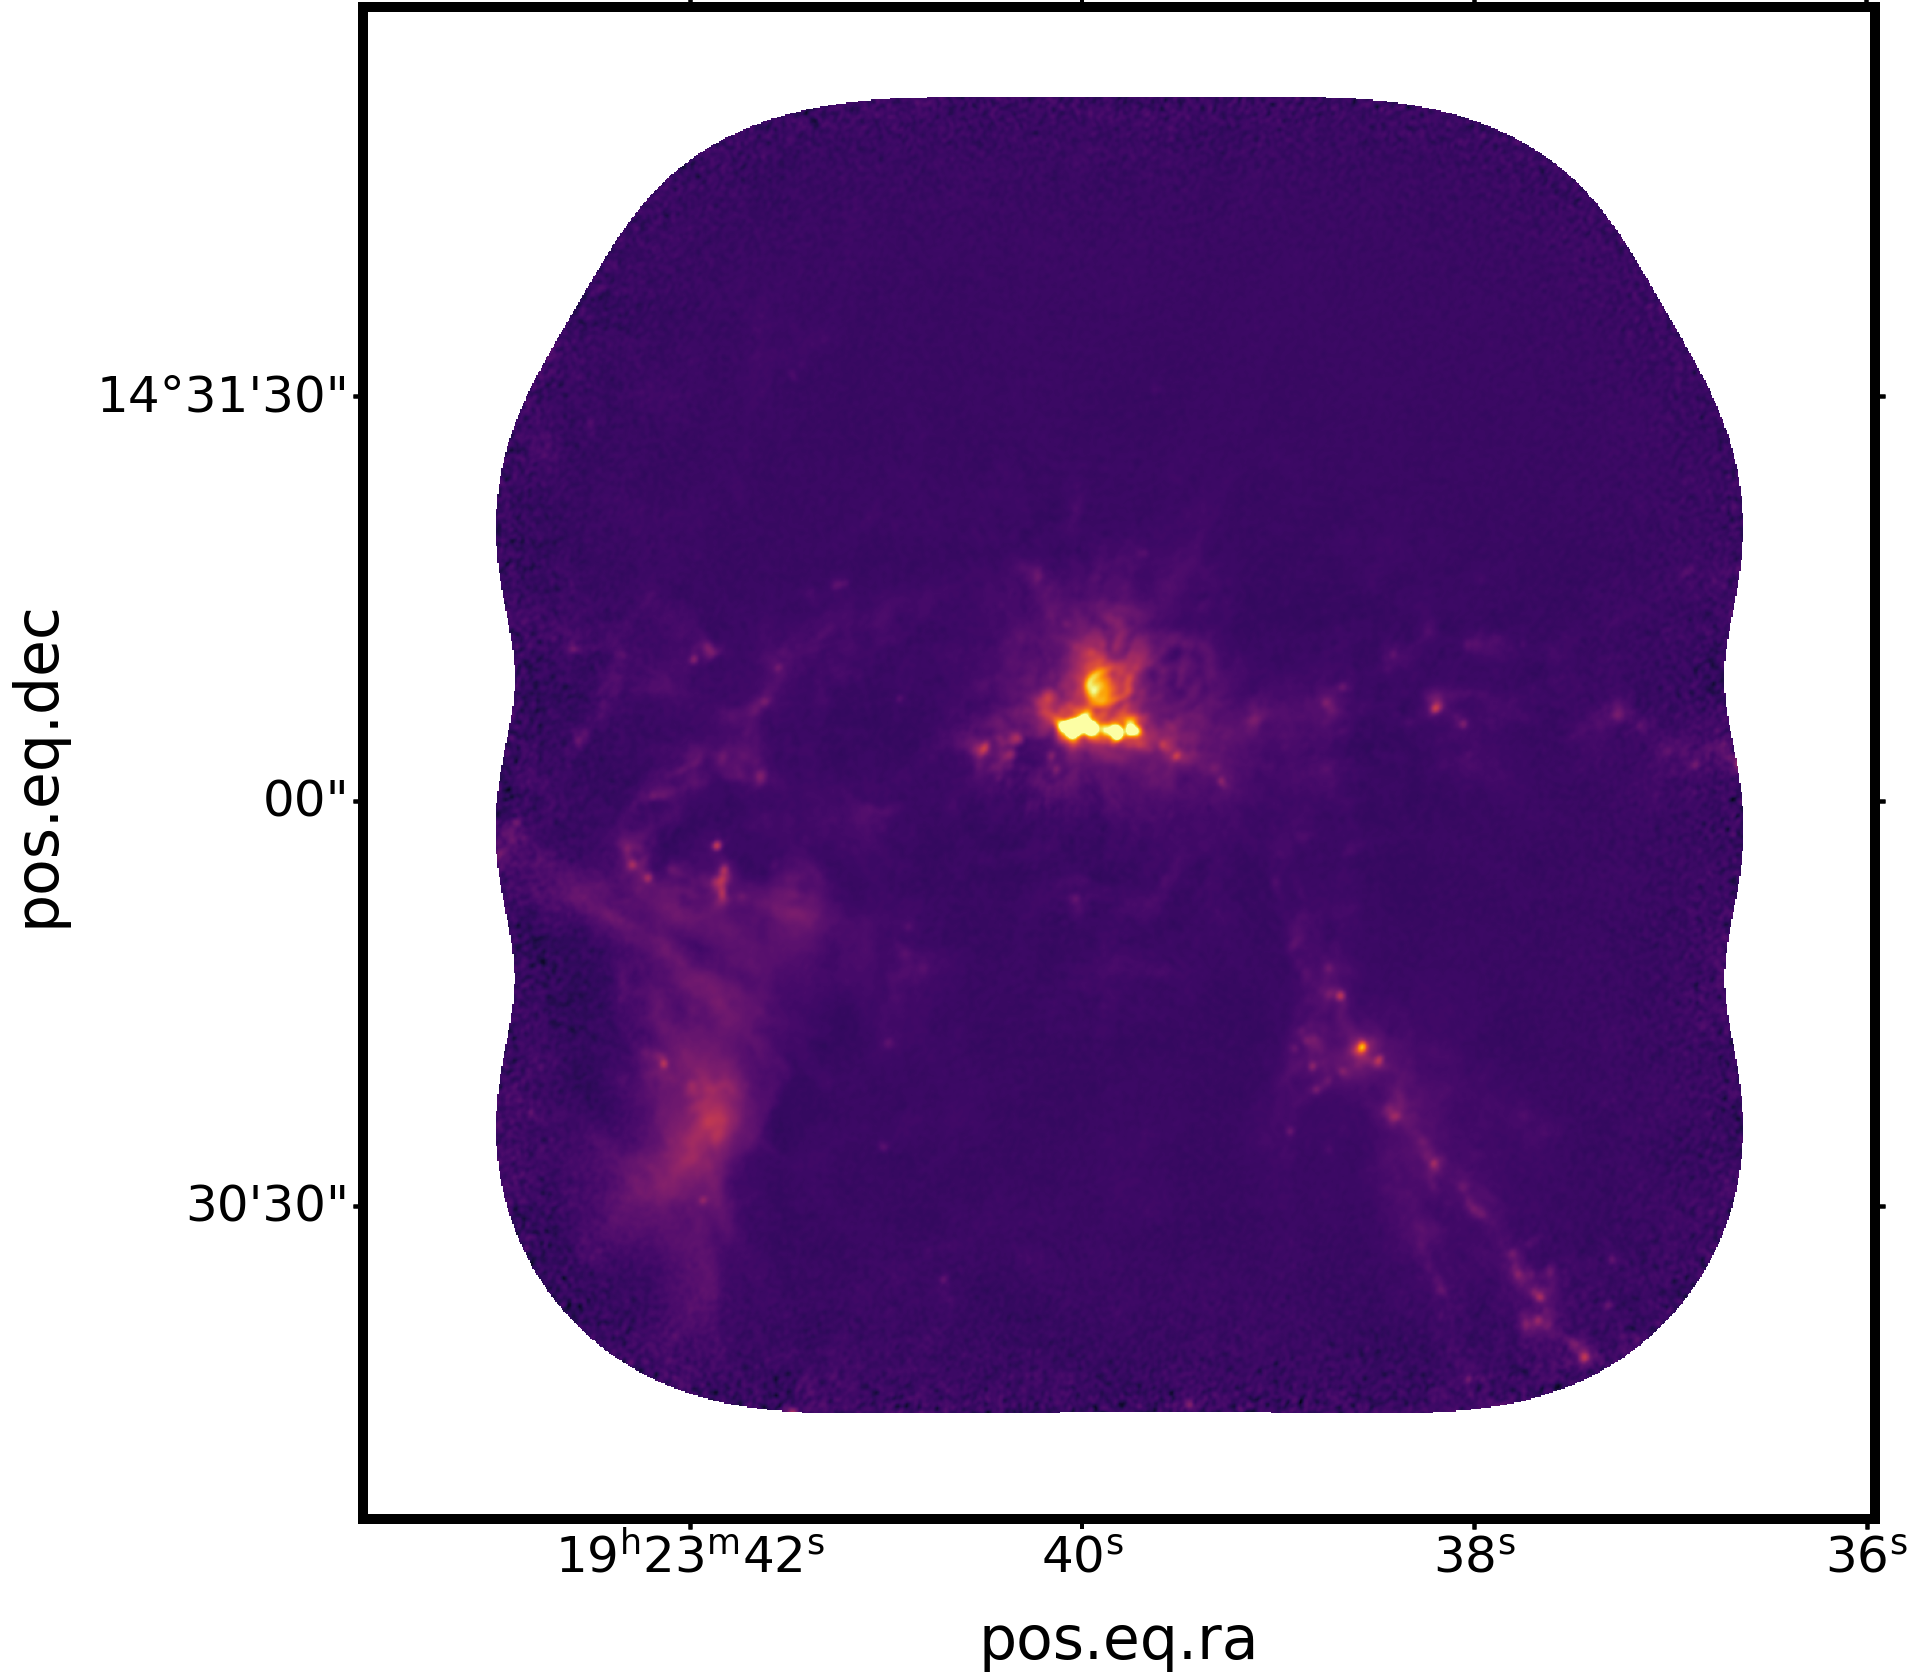

In [3]:
def draw_field_of_view(ax, image_highres, wcs_highres, wcs_lowres, color='r', lw=2, ls='dotted'):
    center = int(image_highres.shape[0]/2)
    index = np.where(np.isnan(image_highres[center,:])==False)[0]
    sky0 = wcs_highres.pixel_to_world(center, np.min(index))
    sky1 = wcs_highres.pixel_to_world(center, np.max(index))
    pix0_in_lowres = wcs_lowres.world_to_pixel(sky0)
    pix1_in_lowres = wcs_lowres.world_to_pixel(sky1)

    circle= Circle(( 
    pix0_in_lowres[0], (pix0_in_lowres[1].item()+pix1_in_lowres[1].item())/2),
    radius=(pix1_in_lowres[1].item()-pix0_in_lowres[1].item())/2, color=color,fill=False, lw=lw, ls=ls)
    ax.add_patch(circle)

fitsdata_b3 = fits.open(Path.w51e_b3_tt0)
image_b3_w51e = fitsdata_b3[0].data
if len(image_b3_w51e.shape)>2:
    image_b3_w51e = fitsdata_b3[0].data[0][0]
hdrB3_w51e_hr = fits.getheader(Path.w51e_b3_tt0)  
    
fitsdata_b3 = fits.open(Path.w51n_b3_tt0)
image_b3_w51n = fitsdata_b3[0].data
if len(image_b3_w51n.shape)>2:
    image_b3_w51n = fitsdata_b3[0].data[0][0]
hdrB3_w51n_hr = fits.getheader(Path.w51n_b3_tt0)  

fitsdata_b6 = fits.open(Path.w51e_b6_tt0)
image_b6_w51e = fitsdata_b6[0].data
if len(image_b6_w51e.shape)>2:
    image_b6_w51e = fitsdata_b6[0].data[0][0]
hdrB6_w51e_hr = fits.getheader(Path.w51e_b6_tt0)  
    
fitsdata_b6 = fits.open(Path.w51n_b6_tt0)
image_b6_w51n = fitsdata_b6[0].data
if len(image_b6_w51n.shape)>2:
    image_b6_w51n = fitsdata_b6[0].data[0][0]
hdrB6_w51n_hr = fits.getheader(Path.w51n_b6_tt0)  

hdrB6_w51e_almaimf = fits.getheader(Path.w51e_b6_almaimf)  
wcsB6_w51e_almaimf = WCS(hdrB6_w51e_almaimf,naxis=2)
beamb6_w51e_almaimf = Beam.from_fits_header(hdrB6_w51e_almaimf)  

hdrB3_w51e_almaimf = fits.getheader(Path.w51e_b3_almaimf)  
wcsB3_w51e_almaimf = WCS(hdrB3_w51e_almaimf,naxis=2)
beamb3_w51e_almaimf = Beam.from_fits_header(hdrB3_w51e_almaimf) 

hdrB6_w51n_almaimf = fits.getheader(Path.w51n_b6_almaimf)  
wcsB6_w51n_almaimf = WCS(hdrB6_w51n_almaimf,naxis=2)
beamb6_w51n_almaimf = Beam.from_fits_header(hdrB6_w51n_almaimf)  

hdrB3_w51n_almaimf = fits.getheader(Path.w51n_b3_almaimf)  
wcsB3_w51n_almaimf = WCS(hdrB3_w51n_almaimf,naxis=2)
beamb3_w51n_almaimf = Beam.from_fits_header(hdrB3_w51n_almaimf)

imageb6_w51e_almaimf = fits.open(Path.w51e_b6_almaimf)[0].data[0][0]
imageb6_w51n_almaimf = fits.open(Path.w51n_b6_almaimf)[0].data[0][0]
coreidx_w51e_fabien = [[2,4,8,11,12,13,14,15,16,17,19,21,22,26,28,29,33,34,38,39],[1,3,5,6,9,10,18,27]] #30, 31, 20 are discarded because they have duplicated pairs in IRS2
coreidx_w51n_fabien = [[1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,19,20,22,23,24,25,26,27,28,29,31,32,33,34,35,37,38,40,41,42,43,44,45,46,47,48,
49,51,52,53,54,55,57,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,84,85,86,87,88,89,90,91,92,94,95,97,99,100,101,102,104,105,106,107,108,109,111,114,117,119,122,123],
[3,5,18,36,56,58,98,113,118,124]]


core_catdata_w51n_b3_b6crit_b3fov = core_catdata(Path.w51n_almaimf_catalog, beamb3_w51n_almaimf,coreidx_w51n_fabien, hrfits=Path.w51n_b3_tt0)

core_catdata_w51n_b3_b6crit_all = core_catdata(Path.w51n_almaimf_catalog, beamb3_w51n_almaimf,coreidx_w51n_fabien, hrfits=None)

fig = plt.figure(figsize=(30,30))
ax1 = fig.add_axes([0.3,0.3,0.7,0.7],projection=wcsB6_w51n_almaimf)
ax1.imshow(imageb6_w51n_almaimf , origin='lower',cmap=plt.get_cmap('inferno'),norm=colors.PowerNorm(gamma=0.5,vmin=-0.0035380786497514836, vmax=0.1014974178034381),)
plot_catalog_on_image(ax1,core_catdata_w51n_b3_b6crit_b3fov ,core_catdata_w51n_b3_b6crit_all , [1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,19,20,22,23,24,25,26,27,28,29,31,32,33,34,35,37,38,40,41,42,43,44,45,46,47,48,
49,51,52,53,54,55,57,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,84,85,86,87,88,89,90,91,92,94,95,97,99,100,101,102,104,105,106,107,108,109,111,114,117,119,122,123],
beam=beamb6_w51n_almaimf,color='cyan',
                    )
plot_catalog_on_image(ax1,hdr_almaimf,Path.w51n_almaimf_catalog , [3,5,18,36,56,58,98,113,118,124],beam=beamb6_w51n_almaimf,color='lime',
                     )
    
add_beam(ax1,550,150, beam_almaimf, scale_almaimf,square=True,square_size=10000)
add_scale_bar(ax1, 450, 200, 0.5*u.pc, scale_almaimf,5.1*u.kpc, xoffset=-0.1,height=4,pad=23)
draw_field_of_view(ax1,image_highres_b3, wcs_highres_b3, wcsB6_w51n_almaimf, color='r', lw=4, ls='dotted') 
draw_field_of_view(ax1,image_highres_b6, wcs_highres_b6, wcsB6_w51n_almaimf, color='yellow', lw=4, ls='dotted')    




ax1.set_xlim(100,1000)    
ax1.set_ylim(70,1060)    
ax1.set_xlabel('RA (ICRS)')
ax1.set_ylabel('DEC (ICRS)')
 

plt.savefig('W51IRS2-fragment1.png')

0 9185.000000006678 6716.9999999978945
1 8918.00000002286 6914.99999998954
2 7041.000000027865 6982.000000019993
3 6098.999999975255 7003.999999996554
4 8094.9999999792335 7086.999999993796
5 8438.999999983282 7166.999999997689
6 8129.000000022367 7167.999999983953
7 8330.000000026102 7176.999999993643
8 7850.999999992927 7188.999999998993
9 8050.000000002395 7206.000000006656
10 7592.000000005981 7213.000000004414
11 7248.000000003661 7246.9999999979445
12 7959.9999999998945 7229.999999994503
13 7191.9999999914635 7233.000000012654
14 8362.000000023227 7271.000000007738
15 7074.999999979755 7289.000000002801
16 7138.00000000043 7304.999999999035
17 7482.999999968164 7304.999999997409
18 7075.999999993917 7317.000000002155
19 7005.000000008456 7320.999999979844
20 7468.999999987119 7330.9999999936235
21 7437.999999975963 7403.999999982154
22 4048.9999999828938 7771.000000002173
23 4223.766121273762 3535.7471763371304
24 6948.513474061568 6440.749659476176
25 7317.76276588264 7217.74999

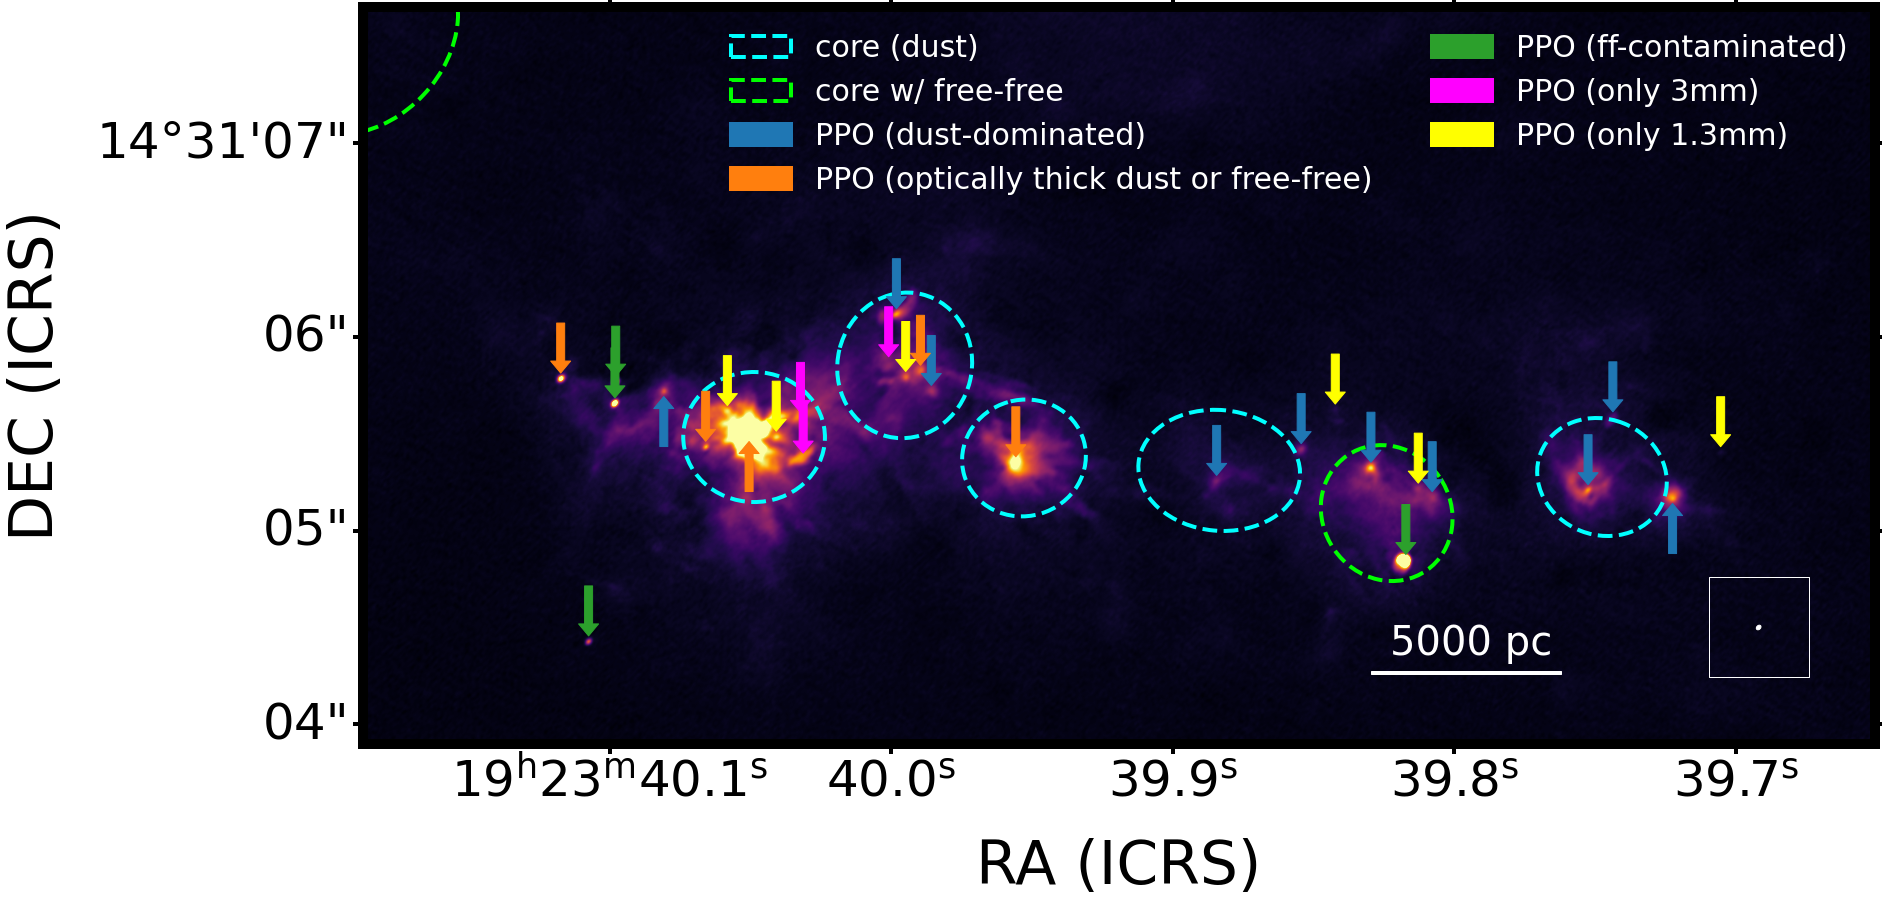

In [5]:
fitsdata_highres = fits.open(Path.w51n_b6_tt0)
image_highres = fitsdata_highres[0].data[0][0]
if len(image_highres.shape)>2:
    image_highres = fitsdata_highres[0].data[0][0]
hdr_highres = fits.getheader(Path.w51n_b6_tt0)  
beam_highres = Beam.from_fits_header(hdr_highres)

wcs_highres = WCS(hdr_highres,naxis=2)

scale_highres = wcs_highres.proj_plane_pixel_scales()[0]
catalog = Table.read(Path.w51n_dendro_matched_catalog_new,format='fits')

fig = plt.figure(figsize=(30,30))
ax1 = fig.add_axes([0.3,0.3,0.7,0.7],projection=wcs_highres)
ax1.imshow(image_highres, origin='lower',cmap=plt.get_cmap('inferno'),vmin=-0.00015829157200641937, vmax=0.00472556868900092)

plot_catalog_on_image(ax1, hdr_highres, Path.w51n_almaimf_catalog , [1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,19,20,22,23,24,25,26,27,28,29,31,32,33,34,35,37,38,40,41,42,43,44,45,46,47,48,
49,51,52,53,54,55,57,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,84,85,86,87,88,89,90,91,92,94,95,97,99,100,101,102,104,105,106,107,108,109,111,114,117,119,122,123],beam=beam_highres,color='cyan',
                    ls='dashed')
plot_catalog_on_image(ax1,hdr_highres,Path.w51n_almaimf_catalog , [3,5,18,36,56,58,98,113,118,124],beam=beam_highres,color='lime',ls='dashed'
                     )
plot_dendrogram_arrow(ax1, catalog, extent=[6700,7700,7000,7900],downarrow=[5,11,16,23,30],wcsNB = wcs_highres,size=20)

#scale_almaimf = wcs_almaimf.proj_plane_pixel_scales()[0]
    
#add_beam(ax1,830,730, beam_almaimf, scale_almaimf,square=True,square_size=10000)
#add_scale_bar(ax1, 1200, 730, 0.1*u.pc, scale_almaimf,5.41*u.kpc, xoffset=-0.3,height=0.5,pad=10)
colors=sns.color_palette("tab10")

circle = Circle((0,0),radius=0, ls='dashed', color='cyan', label='core (dust)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0, ls='dashed', color='lime', label='core w/ free-free',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color=colors[0], label='PPO (dust-dominated)',lw=4,)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color=colors[1], label='PPO (optically thick dust or free-free)',lw=4, )
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color=colors[2], label='PPO (ff-contaminated)',lw=4, )
ax1.add_patch(circle)

circle = Circle((0,0),radius=0,  color='magenta', label='PPO (only 3mm)',lw=4, )
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='yellow', label='PPO (only 1.3mm)',lw=4, )
ax1.add_patch(circle)




add_beam(ax1,8550,7000, beam_highres, scale_highres,square=True,square_size=10000)
add_scale_bar(ax1, 8050, 6940, 5000*u.au, scale_highres,5.1*u.kpc, xoffset=-0.3,height=4,pad=25, forceint=True)
    

ax1.set_xlim(6750,8700)    
ax1.set_ylim(6850,7800)      
ax1.set_xlabel('RA (ICRS)')
ax1.set_ylabel('DEC (ICRS)')
ax1.legend(ncol=2,fontsize=30, frameon=False, loc='upper right',labelcolor='w')

plt.savefig('W51IRS2-fragment15.png')

In [ ]:
fitsdata_highres = fits.open(w51n_b6_calibrated_pbcor)
image_highres = fitsdata_highres[0].data
if len(image_highres.shape)>2:
    image_highres = fitsdata_highres[0].data[0][0]
hdr_highres = fits.getheader(w51n_b6_calibrated_pbcor)  
beam_highres = Beam.from_fits_header(hdr_highres)

wcs_highres = WCS(hdr_highres,naxis=2)

scale_highres = wcs_highres.proj_plane_pixel_scales()[0]
catalog = Table.read(w51n_dendro_matched_catalog,format='fits')
w51n_xsky_b6 = catalog['b6_xsky'] ; w51n_ysky_b6 = catalog['b6_ysky']
w51n_xsky_b3 = catalog['b3_xsky'] ; w51n_ysky_b3 = catalog['b3_ysky']
xsky_w51n = []
for i,x in enumerate(w51n_xsky_b6):
    if x > 0:
        xsky_w51n.append(x)
    else:
        xsky_w51n.append(w51n_xsky_b3[i])
ysky_w51n = []
for i,x in enumerate(w51n_ysky_b6):
    if x > 0:
        ysky_w51n.append(x)
    else:
        ysky_w51n.append(w51n_ysky_b3[i])


skysource= np.vstack((xsky_w51n, ysky_w51n)).T
xysource = wcs_almaimf.wcs_world2pix(skysource,0)


fig = plt.figure(figsize=(30,30))
ax1 = fig.add_axes([0.2,0.2,0.8,0.8],projection=wcs_almaimf)
plot_catalog_on_image(ax1,image_almaimf,hdr_almaimf,cat_w51n,isb3=False,beam=beam_almaimf,use_criteria=True,color='w',
                     vmin=-0.0021462059082253933, vmax=0.0696009927100514, ispower=True,ls='solid',xysource=xysource, ffcont=True)
plot_dendrogram_new(ax1, catalog, wcsNB = wcs_almaimf,size=40,facecolor='cyan')

scale_almaimf = wcs_almaimf.proj_plane_pixel_scales()[0]
    
add_beam(ax1,250,150, beam_almaimf, scale_almaimf,square=True,square_size=10000)
add_scale_bar(ax1, 450, 130, 0.5*u.pc, scale_almaimf,5.1*u.kpc, xoffset=-0.07,height=4,pad=20)
    

ax1.set_xlim(100,1000)    
ax1.set_ylim(100,900)      
ax1.set_xlabel('RA (ICRS)')
ax1.set_ylabel('DEC (ICRS)')
 

plt.savefig('W51IRS2-fragment156.png')

NameError: name 'w51n_b6_calibrated_pbcor' is not defined

510.0000000000406 AU
202.22039828145088 450 130 4


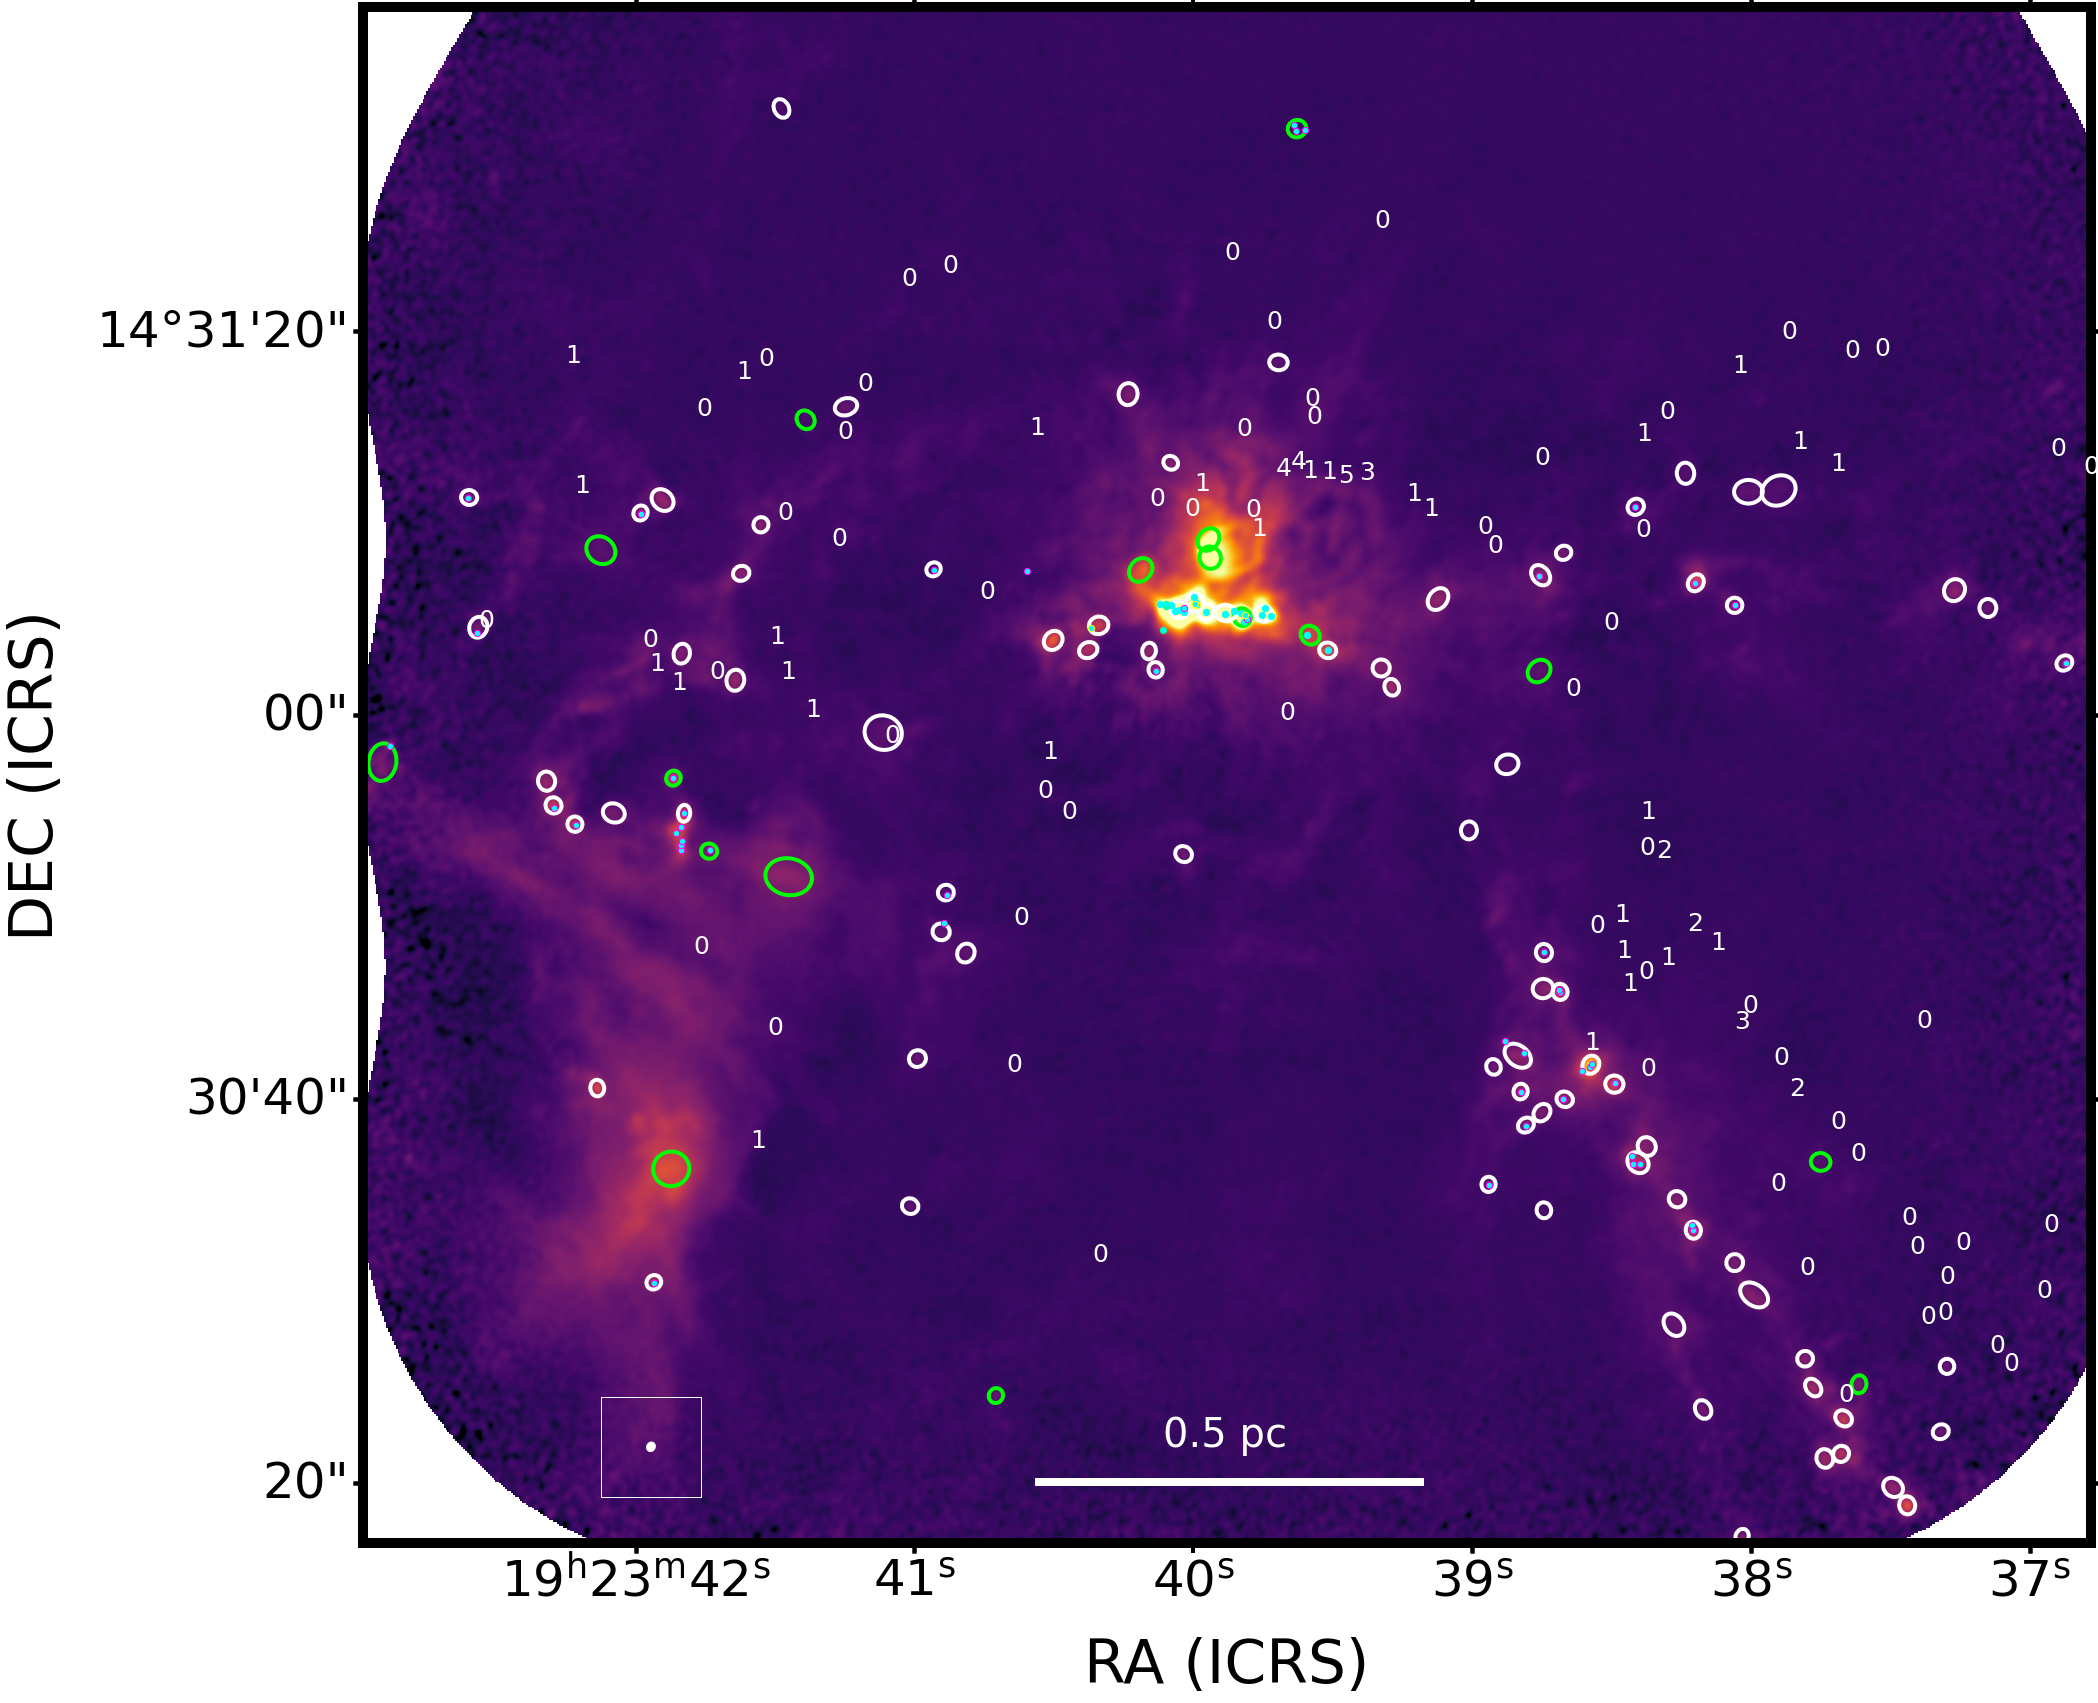

In [ ]:
fitsdata_highres = fits.open(w51n_b6_calibrated_pbcor)
image_highres = fitsdata_highres[0].data
if len(image_highres.shape)>2:
    image_highres = fitsdata_highres[0].data[0][0]
hdr_highres = fits.getheader(w51n_b6_calibrated_pbcor)  
beam_highres = Beam.from_fits_header(hdr_highres)

wcs_highres = WCS(hdr_highres,naxis=2)

scale_highres = wcs_highres.proj_plane_pixel_scales()[0]
catalog = Table.read(w51n_dendro_matched_catalog,format='fits')
w51n_xsky_b6 = catalog['b6_xsky'] ; w51n_ysky_b6 = catalog['b6_ysky']
w51n_xsky_b3 = catalog['b3_xsky'] ; w51n_ysky_b3 = catalog['b3_ysky']
xsky_w51n = []
for i,x in enumerate(w51n_xsky_b6):
    if x > 0:
        xsky_w51n.append(x)
    else:
        xsky_w51n.append(w51n_xsky_b3[i])
ysky_w51n = []
for i,x in enumerate(w51n_ysky_b6):
    if x > 0:
        ysky_w51n.append(x)
    else:
        ysky_w51n.append(w51n_ysky_b3[i])


skysource= np.vstack((xsky_w51n, ysky_w51n)).T
xysource = wcs_almaimf.wcs_world2pix(skysource,0)


fig = plt.figure(figsize=(30,30))
ax1 = fig.add_axes([0.2,0.2,0.8,0.8],projection=wcs_almaimf)
plot_catalog_on_image(ax1,image_almaimf,hdr_almaimf,cat_w51n,isb3=False,beam=beam_almaimf,use_criteria=True,color='w',
                     vmin=-0.0021462059082253933, vmax=0.0696009927100514, ispower=True,ls='solid',xysource=xysource, ffcont=True, fontsize=25)
plot_dendrogram_new(ax1, catalog, wcsNB = wcs_almaimf,size=40,facecolor='cyan')

scale_almaimf = wcs_almaimf.proj_plane_pixel_scales()[0]
    
add_beam(ax1,250,150, beam_almaimf, scale_almaimf,square=True,square_size=10000)
add_scale_bar(ax1, 450, 130, 0.5*u.pc, scale_almaimf,5.1*u.kpc, xoffset=-0.07,height=4,pad=20)
    

ax1.set_xlim(100,1000)    
ax1.set_ylim(100,900)      
ax1.set_xlabel('RA (ICRS)')
ax1.set_ylabel('DEC (ICRS)')
 

plt.savefig('W51IRS2-fragment157.png')

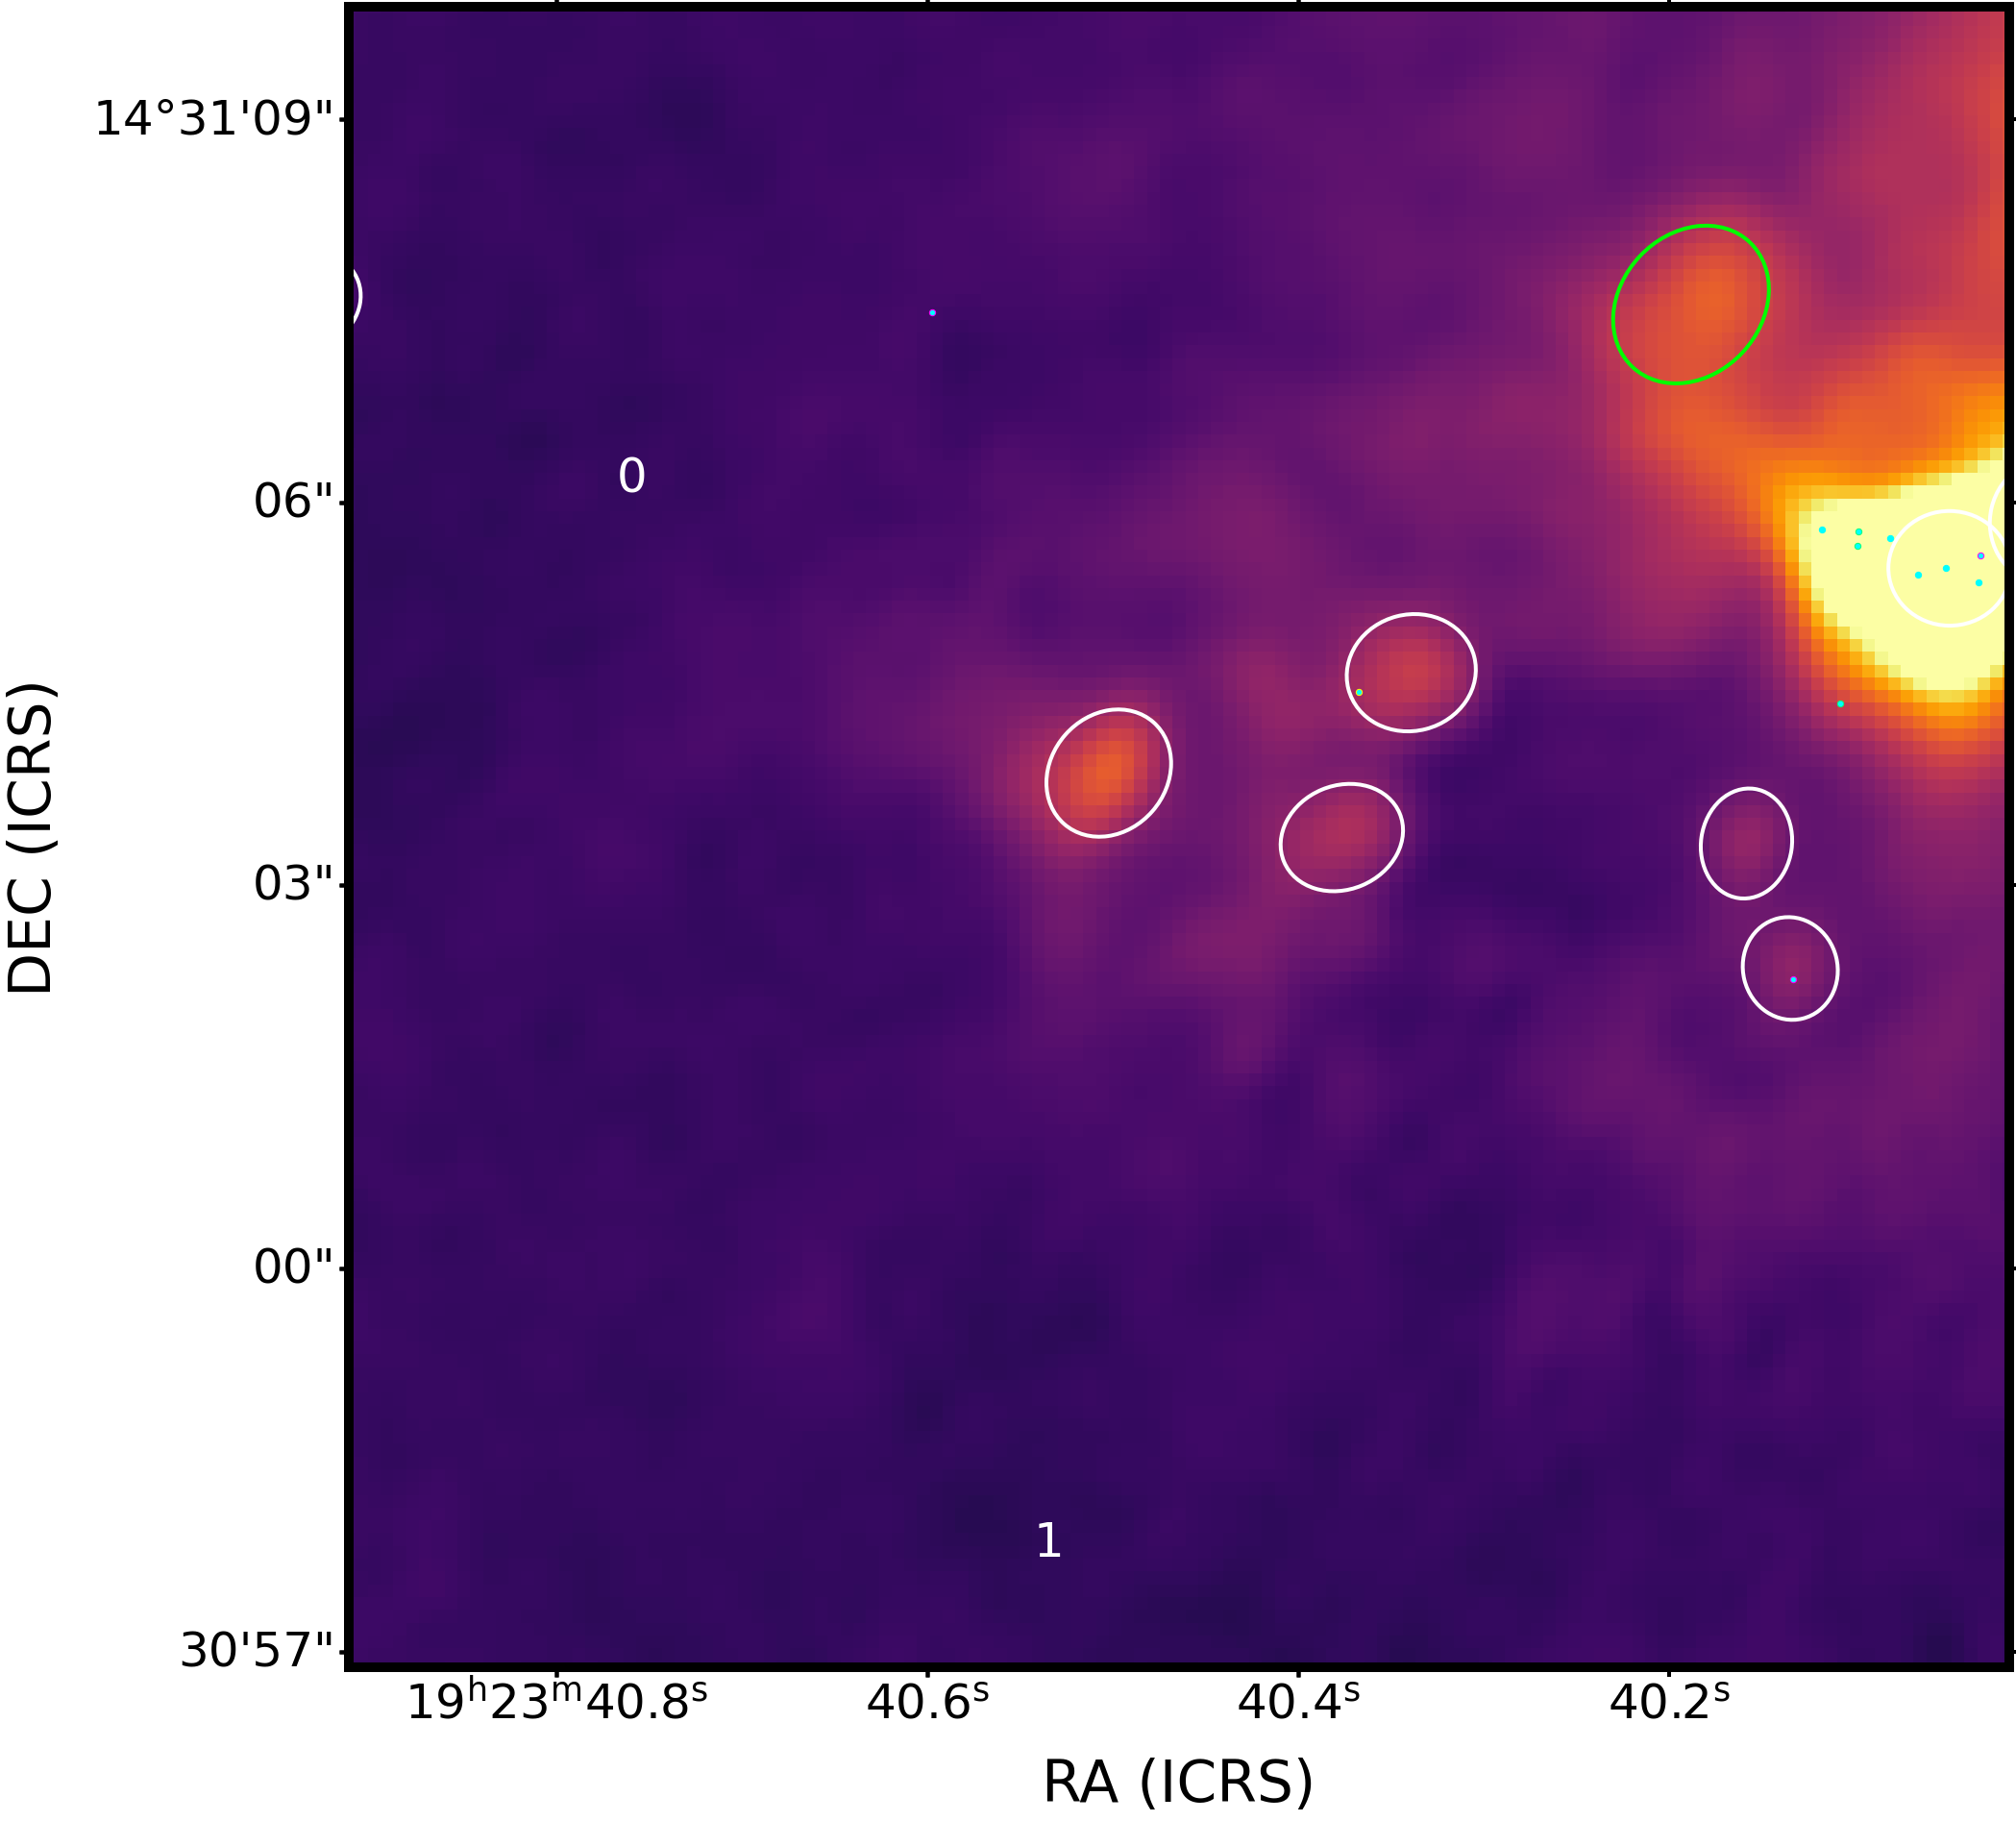

In [ ]:
fitsdata_highres = fits.open(w51n_b6_calibrated_pbcor)
image_highres = fitsdata_highres[0].data
if len(image_highres.shape)>2:
    image_highres = fitsdata_highres[0].data[0][0]
hdr_highres = fits.getheader(w51n_b6_calibrated_pbcor)  
beam_highres = Beam.from_fits_header(hdr_highres)

wcs_highres = WCS(hdr_highres,naxis=2)

scale_highres = wcs_highres.proj_plane_pixel_scales()[0]
catalog = Table.read(w51n_dendro_matched_catalog,format='fits')
w51n_xsky_b6 = catalog['b6_xsky'] ; w51n_ysky_b6 = catalog['b6_ysky']
w51n_xsky_b3 = catalog['b3_xsky'] ; w51n_ysky_b3 = catalog['b3_ysky']
xsky_w51n = []
for i,x in enumerate(w51n_xsky_b6):
    if x > 0:
        xsky_w51n.append(x)
    else:
        xsky_w51n.append(w51n_xsky_b3[i])
ysky_w51n = []
for i,x in enumerate(w51n_ysky_b6):
    if x > 0:
        ysky_w51n.append(x)
    else:
        ysky_w51n.append(w51n_ysky_b3[i])


skysource= np.vstack((xsky_w51n, ysky_w51n)).T
xysource = wcs_almaimf.wcs_world2pix(skysource,0)


fig = plt.figure(figsize=(30,30))
ax1 = fig.add_axes([0.2,0.2,0.8,0.8],projection=wcs_almaimf)
plot_catalog_on_image(ax1,image_almaimf,hdr_almaimf,cat_w51n,isb3=False,beam=beam_almaimf,use_criteria=True,color='w',
                     vmin=-0.0021462059082253933, vmax=0.0696009927100514, ispower=True,ls='solid',xysource=xysource, ffcont=True, fontsize=50,
                     )
plot_dendrogram_new(ax1, catalog, wcsNB = wcs_almaimf,size=40,facecolor='cyan')

scale_almaimf = wcs_almaimf.proj_plane_pixel_scales()[0]
    
#add_beam(ax1,250,150, beam_almaimf, scale_almaimf,square=True,square_size=10000)
#add_scale_bar(ax1, 450, 130, 0.5*u.pc, scale_almaimf,5.1*u.kpc, xoffset=-0.07,height=4,pad=20)
    

ax1.set_xlim(400,530)    
ax1.set_ylim(500,630)      
ax1.set_xlabel('RA (ICRS)')
ax1.set_ylabel('DEC (ICRS)')
 

    

21.639999999997837 AU
92.42144177450092 8200 6950 4


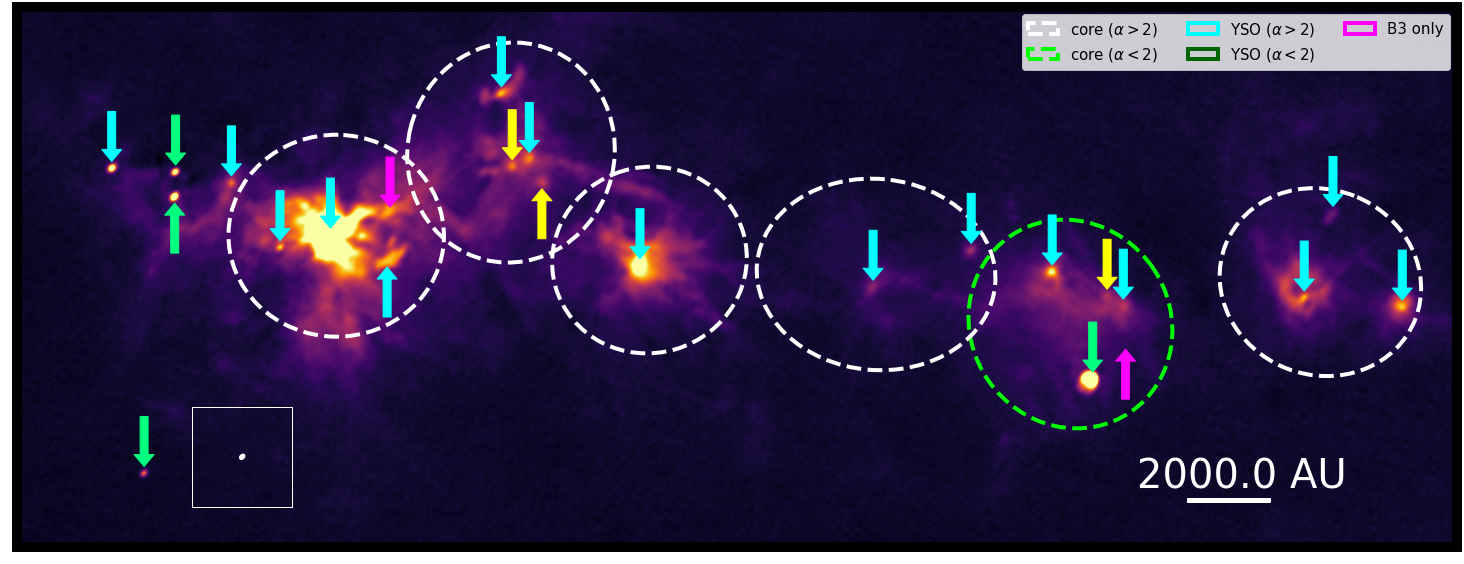

In [ ]:













fig = plt.figure(figsize=(20,20))
ax1 = fig.add_axes([0.0,0.0,1.0,1.0])
plot_catalog_on_image(ax1,image_highres,hdr_highres,cat_w51n,isb3=False,beam=beam_almaimf,use_criteria=True,ffcont=True,color='w',
                     vmin=-0.000293198, vmax=0.004420036895299709)
plot_dendrogram_arrow(ax1, catalog, extent=[6900,8500,6900,7500],downarrow=[2,7,12,20],wcsNB = wcs_highres,size=20)
add_beam(ax1,7150,7000, beam_highres, scale_highres,square=True,square_size=10000)
add_scale_bar(ax1, 8200, 6950, 2e3*u.au, scale_highres,5.41*u.kpc, xoffset=-1,height=4,pad=15)
ax1.set_xlim(6900,8500)    
ax1.set_ylim(6900,7500)
ax1.set_xticks([])
ax1.set_yticks([])

circle = Circle((0,0),radius=0, ls='dashed', color='w', label=r'core ($\alpha>2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0, ls='dashed', color='lime', label=r'core ($\alpha<2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='cyan', label=r'YSO ($\alpha>2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='darkgreen', label=r'YSO ($\alpha<2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='magenta', label='B3 only',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='yellow', label='B6 only',lw=4, fill=False)
#ax1.set_xlabel('RA (ICRS)')
#ax1.set_ylabel('DEC (ICRS)')
ax1.legend(ncol=3,fontsize=15)
plt.savefig('W51IRS2-fragment2_arrow.png')

21.639999999997837 AU
92.42144177450092 8200 6950 4


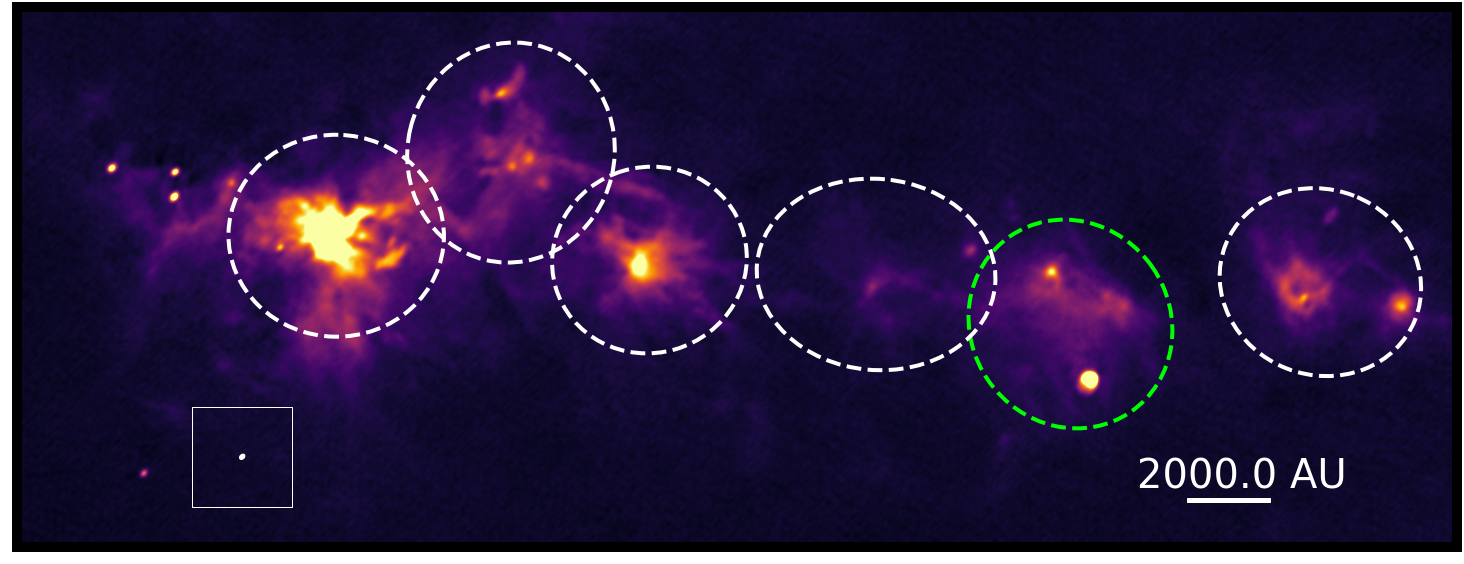

In [ ]:













fig = plt.figure(figsize=(20,20))
ax1 = fig.add_axes([0.0,0.0,1.0,1.0])
plot_catalog_on_image(ax1,image_highres,hdr_highres,cat_w51n,isb3=False,beam=beam_almaimf,use_criteria=True,ffcont=True,color='w',
                     vmin=-0.000293198, vmax=0.004420036895299709)
#plot_dendrogram_arrow(ax1, catalog, extent=[6900,8500,6900,7500],downarrow=[2,7,12,20],wcsNB = wcs_highres,size=20)
add_beam(ax1,7150,7000, beam_highres, scale_highres,square=True,square_size=10000)
add_scale_bar(ax1, 8200, 6950, 2e3*u.au, scale_highres,5.41*u.kpc, xoffset=-1,height=4,pad=15)
ax1.set_xlim(6900,8500)    
ax1.set_ylim(6900,7500)
ax1.set_xticks([])
ax1.set_yticks([])

circle = Circle((0,0),radius=0, ls='dashed', color='w', label=r'core ($\alpha>2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0, ls='dashed', color='lime', label=r'core ($\alpha<2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='cyan', label=r'YSO ($\alpha>2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='darkgreen', label=r'YSO ($\alpha<2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='magenta', label='B3 only',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='yellow', label='B6 only',lw=4, fill=False)
#ax1.set_xlabel('RA (ICRS)')
#ax1.set_ylabel('DEC (ICRS)')
#ax1.legend(ncol=3,fontsize=15)
plt.savefig('W51IRS2-fragment2_noarrow.png')

541.0000000000432 AU
3.6968576709793717 563.1494965242505 574.1918266185605 0.4


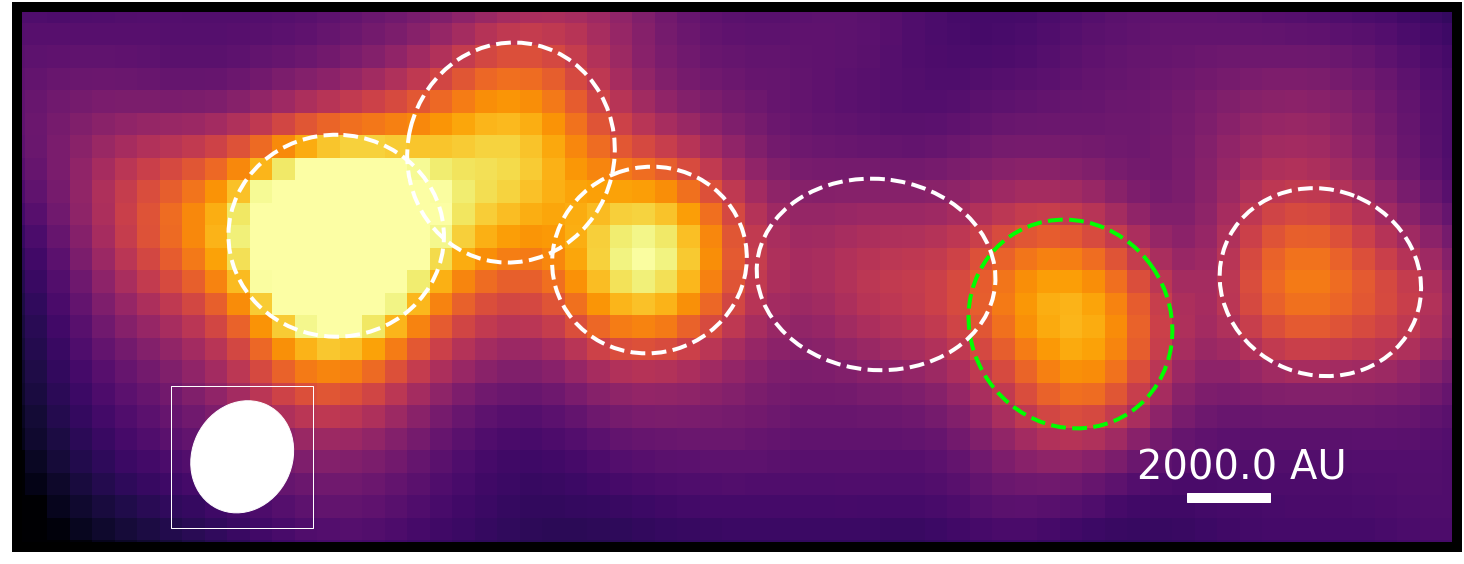

In [ ]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_axes([0.0,0.0,1.0,1.0])
plot_catalog_on_image(ax1,image_almaimf,hdr_almaimf,cat_w51n,isb3=False,beam=beam_almaimf,use_criteria=True,ffcont=True,color='w',
                     vmin=0.005380786497514836, vmax=0.4014974178034381,ispower=True)
world_coord1 = wcs_highres.pixel_to_world(6900, 6900)
world_coord2 = wcs_highres.pixel_to_world(8500, 7500)
world_coord3 = wcs_highres.pixel_to_world(7150, 7000)
world_coord4 = wcs_highres.pixel_to_world(8200, 6950)

pix_coord1 = wcs_almaimf.world_to_pixel(world_coord1)
pix_coord2 = wcs_almaimf.world_to_pixel(world_coord2)
pix_coord3 = wcs_almaimf.world_to_pixel(world_coord3)
pix_coord4 = wcs_almaimf.world_to_pixel(world_coord4)
#plot_dendrogram_arrow(ax1, catalog, extent=[6900,8500,6900,7500],downarrow=[2,7,12,20],wcsNB = wcs_highres,size=20)
add_beam(ax1,pix_coord3[0],pix_coord3[1], beam_almaimf, scale_almaimf,square=True,square_size=20000)
add_scale_bar(ax1, pix_coord4[0],pix_coord4[1], 2e3*u.au, scale_almaimf,5.41*u.kpc, xoffset=-1,height=0.4,pad=1)
ax1.set_xlim(pix_coord1[0],pix_coord2[0])    
ax1.set_ylim(pix_coord1[1],pix_coord2[1])
ax1.set_xticks([])
ax1.set_yticks([])

circle = Circle((0,0),radius=0, ls='dashed', color='w', label=r'core ($\alpha>2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0, ls='dashed', color='lime', label=r'core ($\alpha<2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='cyan', label=r'YSO ($\alpha>2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='darkgreen', label=r'YSO ($\alpha<2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='magenta', label='B3 only',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='yellow', label='B6 only',lw=4, fill=False)
#ax1.set_xlabel('RA (ICRS)')
#ax1.set_ylabel('DEC (ICRS)')
#ax1.legend(ncol=3,fontsize=15)
plt.savefig('W51IRS2-fragment2_lowres.png')

21.639999999997837 AU
46.21072088725046 7500 6950 4


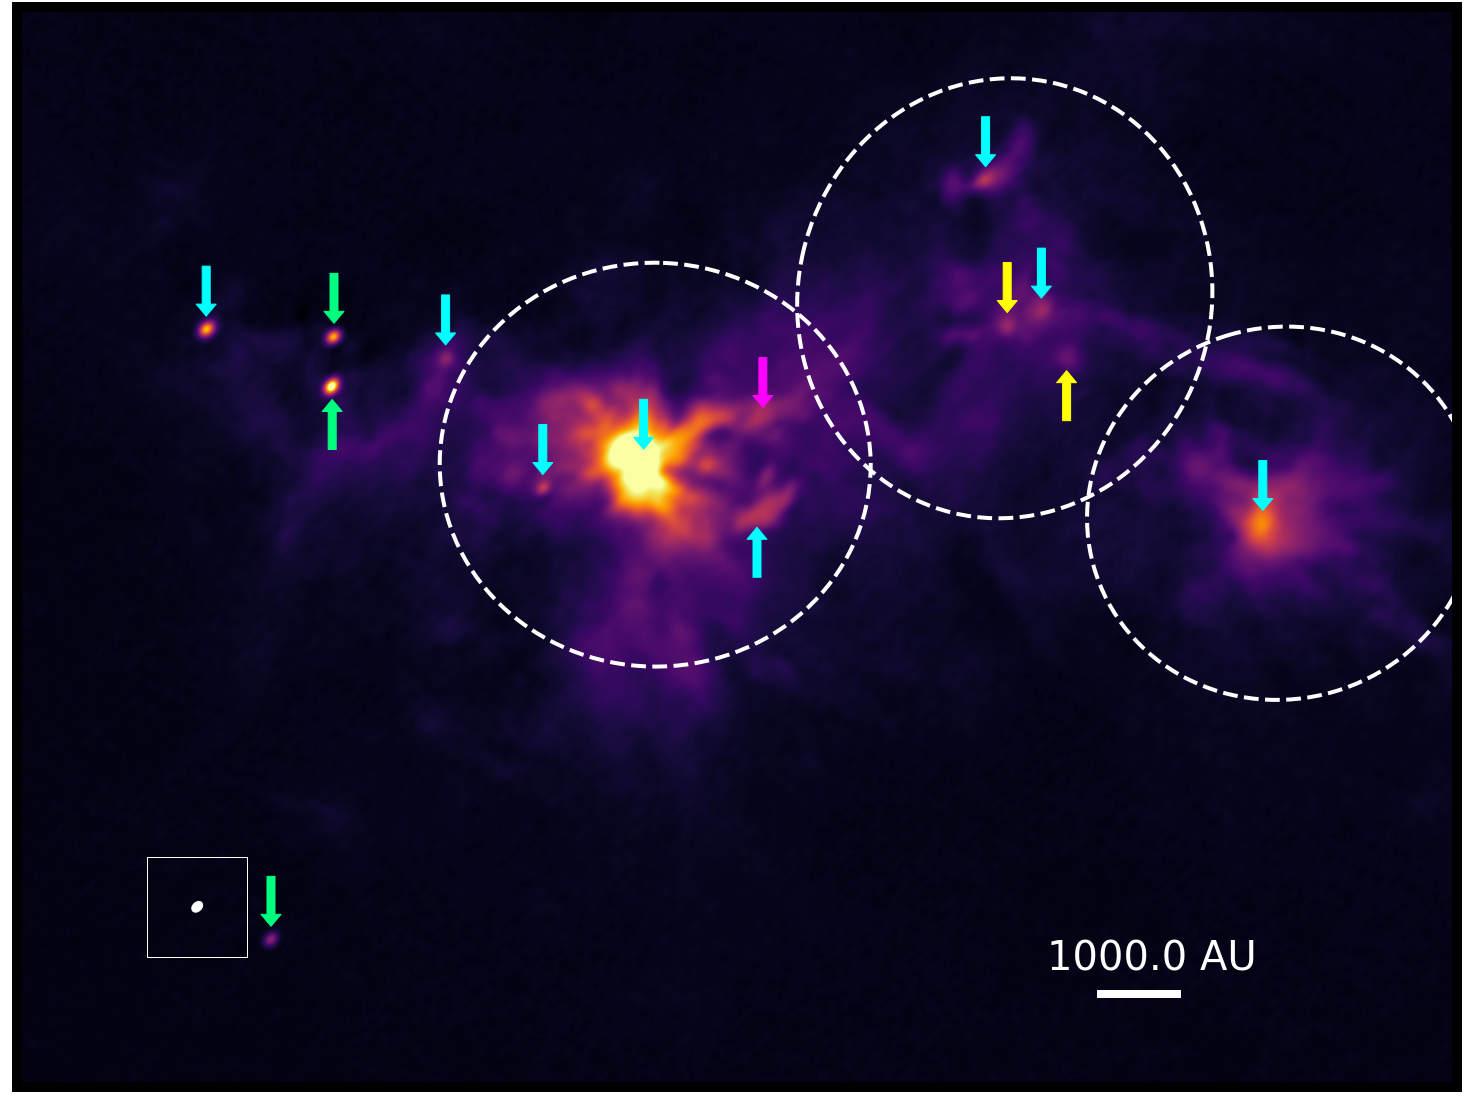

In [ ]:































fig = plt.figure(figsize=(20,20))
ax1 = fig.add_axes([0.0,0.0,1.0,1.0])
plot_catalog_on_image(ax1,image_highres,hdr_highres,cat_w51n,isb3=False,beam=beam_almaimf,use_criteria=True,ffcont=True,color='w',
                     vmin=-0.000293198, vmax=0.008101369698094501)
plot_dendrogram_arrow(ax1, catalog, extent=[6900,7700,6900,7500],downarrow=[2,7,12],wcsNB = wcs_highres,size=20)
add_beam(ax1,7000,7000, beam_highres, scale_highres,square=True,square_size=10000)
add_scale_bar(ax1, 7500, 6950, 1e3*u.au, scale_highres,5.41*u.kpc, xoffset=-1,height=4,pad=15)
ax1.set_xlim(6900,7700)    
ax1.set_ylim(6900,7500)
ax1.set_xticks([])
ax1.set_yticks([])


#ax1.set_xlabel('RA (ICRS)')
#ax1.set_ylabel('DEC (ICRS)')
plt.savefig('W51IRS2-fragment2.png')

In [ ]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_axes([0.0,0.0,1.0,1.0])
plot_catalog_on_image(ax1,image_highres,hdr_highres,cat_w51e,isb3=False,beam=beam_almaimf,use_criteria=True,ffcont=True,color='w',
                     vmin=-0.00007221506578695015, vmax=0.0008449317463340403)
catalog = Table.read(w51e_dendro_matched_catalog,format='fits')
plot_dendrogram_circle(ax1, catalog, wcsNB = wcs_highres,size=20)
add_beam(ax1,6300,6600, beam_highres, scale_highres,square=True,square_size=10000)
add_scale_bar(ax1, 7050, 6600, 1e3*u.au, scale_highres,5.41*u.kpc, xoffset=-1,height=4,pad=15)
ax1.set_xlim(6200,7200)    
ax1.set_ylim(6500,7200)
ax1.set_xticks([])
ax1.set_yticks([])

circle = Circle((0,0),radius=0, ls='dashed', color='w', label=r'core ($\alpha>2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0, ls='dashed', color='lime', label=r'core ($\alpha<2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='cyan', label=r'YSO ($\alpha>2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='darkgreen', label=r'YSO ($\alpha<2$)',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='magenta', label='B3 only',lw=4, fill=False)
ax1.add_patch(circle)
circle = Circle((0,0),radius=0,  color='yellow', label='B6 only',lw=4, fill=False)
ax1.add_patch(circle)
ax1.legend(loc='upper left',fontsize=40,frameon=False, labelcolor='w',ncol=2)

#ax1.set_xlabel('RA (ICRS)')
#ax1.set_ylabel('DEC (ICRS)')
plt.savefig('W51E-fragment3.png')

In [ ]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_axes([0.0,0.0,1.0,1.0])
plot_catalog_on_image(ax1,image_highres,hdr_highres,cat_w51e,isb3=False,beam=beam_almaimf,use_criteria=True,ffcont=True,color='w',
                     vmin=-0.0001582915720064193, vmax=0.0051303084896368875)
catalog = Table.read(w51e_dendro_matched_catalog,format='fits')
plot_dendrogram_circle(ax1, catalog, wcsNB = wcs_highres,size=20)
add_beam(ax1,7050,5080, beam_highres, scale_highres,square=True,square_size=10000)
add_scale_bar(ax1, 7420, 5080, 1e3*u.au, scale_highres,5.41*u.kpc, xoffset=-1,height=4,pad=15)
ax1.set_xlim(7000,7550)    
ax1.set_ylim(5050,5800)
ax1.set_xticks([])
ax1.set_yticks([])
#ax1.set_xlabel('RA (ICRS)')
#ax1.set_ylabel('DEC (ICRS)')
plt.savefig('W51E-fragment4.png')